Business Problem: Predict the onset of diabetes based on diagnostic measures


Dataset: Pima Indians Diabetes Database

Collaborators :
UCI Machine Learning (Owner) and Kaggle Team (Admin)



https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

About Dataset

Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Content

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Inspiration

Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?



diabetes.csv(23.87 kB)

About this file

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

There are 9 variables and 768 observations:

Pregnancies : Number of times pregnant

Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure : Diastolic blood pressure (mm Hg)

SkinThickness : Triceps skin fold thickness (mm)

Insulin : 2-Hour serum insulin (mu U/ml)

BMI : Body mass index (weight in kg/(height in m)^2)

DiabetesPedigreeFunction : Diabetes pedigree function

Age : Age (years)

Outcome : Class variable (0 or 1) 268 of 768 are 1, the others are 0

Steps:

1. Exploratory Data Analysis
2. Data Preprocessing
3. Model & Prediction
4. Model Evaluation
5. Model Validation: Holdout
6. Model Validation: 10-Fold Cross Validation
7. Prediction for A New Observation

# 1. Exploratory Data Analysis (EDA)

Importing the libraries we need and making arrangements for the outputs:

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay #plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

My functions for outliers:

In [87]:
# For threshold value calculation
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):  # Usually values of 0.25 and 0.75 are chosen. Here, I chose the values 0.05 and 0.95 because I wanted to subjectively select the most outlier values.
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range    #up limit  : 3.quartile + 1.5 Iqr
    low_limit = quartile1 - 1.5 * interquantile_range   #low limit : 1.quartile - 1.5 Iqr
    return low_limit, up_limit


# To calculate whether there is an outlier:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# To replace outliers with threshold values
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

pd.set_option('display.max_columns', None)                   # show all columns
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # show 3 digits after the comma
pd.set_option('display.width', 500)                          # a wide field of view

In [88]:
df = pd.read_csv("/content/diabetes.csv")

In [89]:
# first 5 observations of the diabetes dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [90]:
df.shape
# (768, 9)

(768, 9)

Analysis of Target Variable:

In [91]:
# Number of classes of the target variable
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

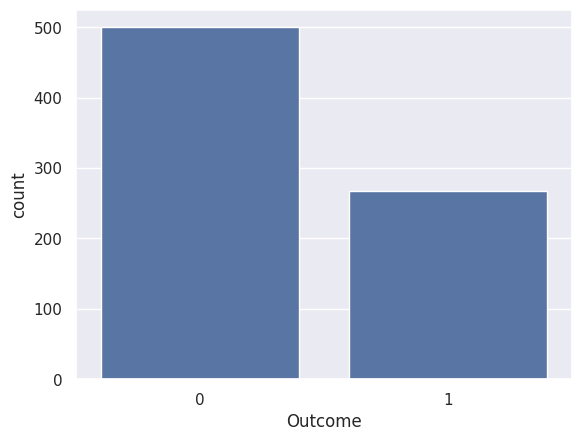

In [92]:
# Graphical representation of the target variable
sns.countplot(x="Outcome", data=df)
plt.show()

In [93]:
# Percentage of classes of the target variable
100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

Analysis of Features:

In [94]:
# descriptive statistics of variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


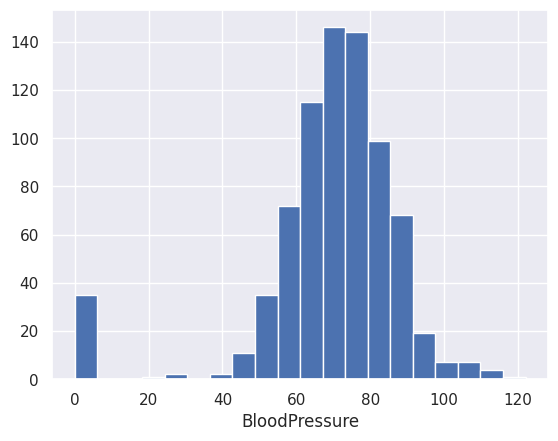

In [95]:
# Graphical representation of the BloodPressure features
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

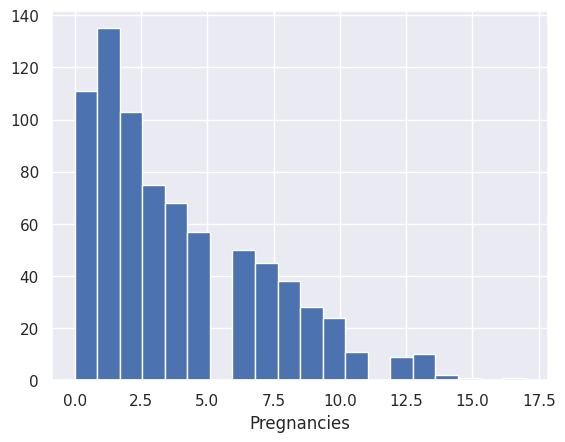

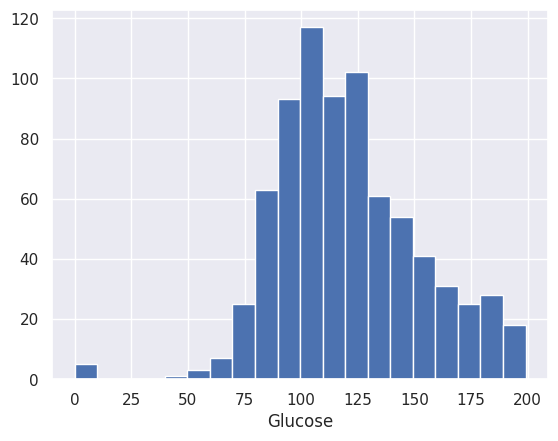

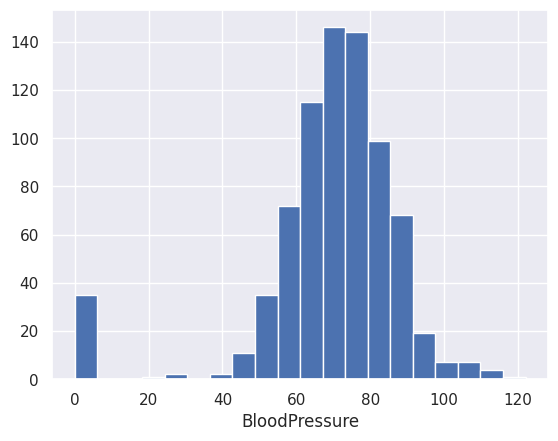

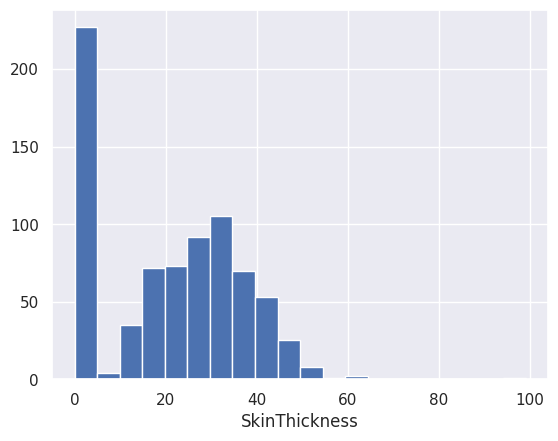

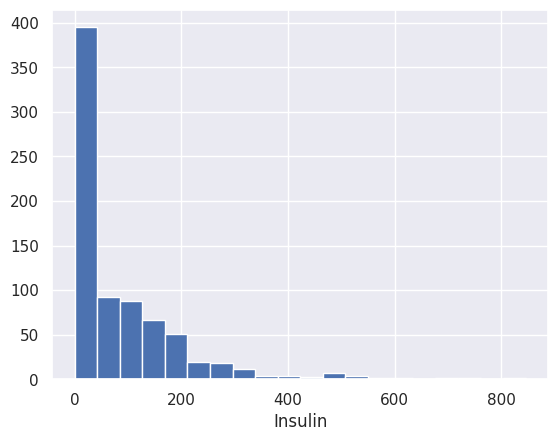

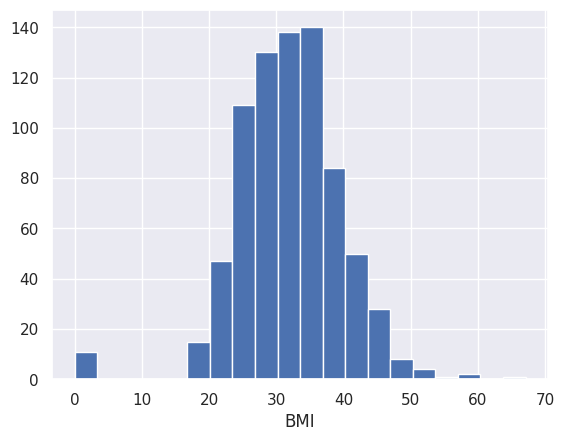

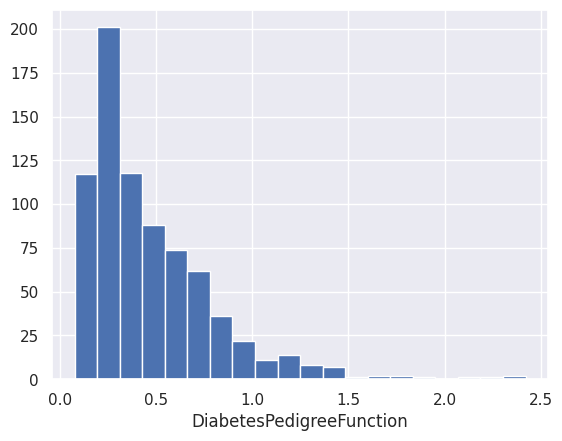

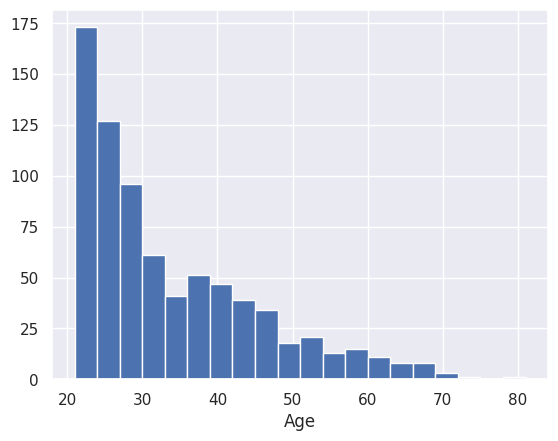

In [96]:
# Graphical representation of all features
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)

cols = [col for col in df.columns if "Outcome" not in col]

for col in cols:
  plot_numerical_col(df, col)

Target vs Features: Averages of independent variables based on target variable:

In [97]:
#df.groupby("Outcome").agg({"Pregnancies": "mean"})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




Above, we looked at the means of each of the independent variables for classes 0 (non-diabetic) and 1 (diabetic) of the target variable. For example, the glucose average of class 0 without diabetes is 109.98, and the glucose average of class 1 with diabetes is 141.25. The average age of people without diabetes is 31, and the average age of people with diabetes is 37. When we observe other variables in this regard, the results seem logical.

# 2. Data Preprocessing

In [98]:
df.shape    # (768, 9)
df.head()   # first 5 observations of the diabetes dataset

df.isnull().sum()  # Checking for missing values

df.describe().T    # Descriptive statistics of variables

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


There are no missing values in the dataset, but when we look at the descriptive statistics, there are non-significant "0" values - such as blood pressure being "0". These zeros were perhaps missing values. If there are missing values, an action can be taken on these values. But for now I'm skipping this part...

Outliers:

In [99]:
for col in cols:
    print(col, check_outlier(df, col))
# When we checked the outliers, Insulin gave the "True" result, the others gave the "False" result. So there is an anomaly in the insulin variable.

# I replace outliers with threshold values I set
replace_with_thresholds(df, "Insulin")

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


Scaling of variables:

We standardized it. RobustScaler subtracts the median from the values of all observation units and divides it by the range.

The “Robust Scaler” is less affected by outliers than the “Standard Scaler”. That's why I chose it.

In [100]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


# 3. Model & Prediction (Logistic Regression)


In [101]:
y = df["Outcome"] # Target variable

X = df.drop(["Outcome"], axis=1) # We excluded the target variable from our independent variables.

In [102]:
log_model = LogisticRegression().fit(X, y)  # Establishing the logistic regression model

log_model.intercept_  #intercept
log_model.coef_       #coefficient

y_pred = log_model.predict(X)  # predict
y_pred[0:10]  # estimated values
y[0:10]       # actual values

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

# 4. Model Evaluation

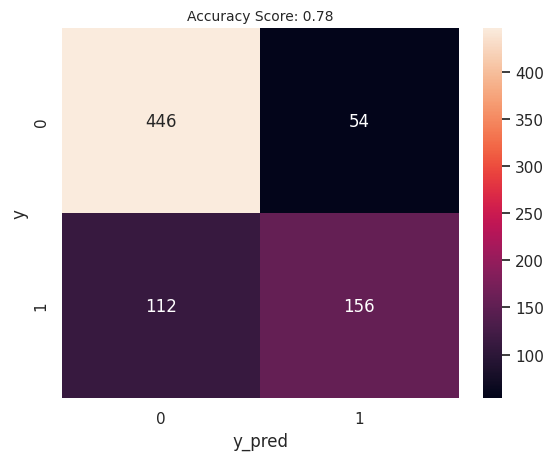

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



0.8393955223880598

In [103]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred))


# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)
# 0.83939

# 5. Model Validation: Holdout

In the model validation step, we divide our dataset into two: testing(%20) and training (%80)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

# After splitting the data set into two, we rebuild the model:
log_model = LogisticRegression().fit(X_train, y_train)

# We make prediction by giving the test set to the model.
y_pred = log_model.predict(X_test)

# for "roc_auc_score"
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# Results when we use all the data:
# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score : 0.65
# AUC : 0.83939

# Results when we do holdout:
# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63
# AUC : 0.87

#RocCurveDisplay(log_model, X_test, y_test) # Roc Curve
#plt.title('ROC Curve')
#plt.plot([0, 1], [0, 1], 'r--')
#plt.show()

# AUC
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



0.8755652016639537

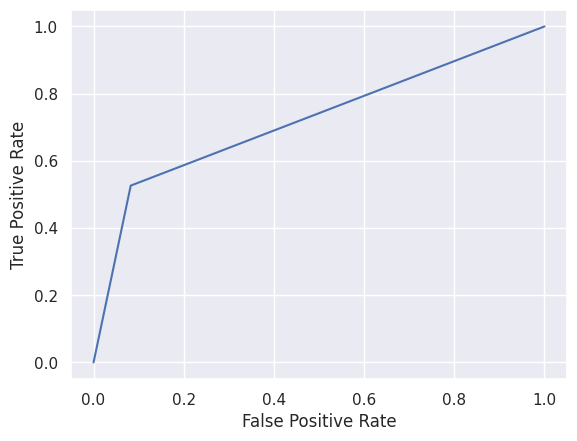

In [105]:
from sklearn.metrics import RocCurveDisplay, roc_curve

y_pred = log_model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# 6. Model Validation: 10-Fold Cross Validation

Since my data set is not very large, I will cross-validate from the total observation. I won't separate this into training and testing.

I will do 5-fold cross validation

In [106]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

# Since my data set is not very large, I will cross-validate from the total observation. I won't separate this into training and testing.

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
# Accuracy: 0.7721
cv_results['test_precision'].mean()
# Precision: 0.7192
cv_results['test_recall'].mean()
# Recall: 0.5747
cv_results['test_f1'].mean()
# F1-score: 0.6371
cv_results['test_roc_auc'].mean()
# AUC: 0.8327

# Accuracy  : doğru sınıflandırma oranım
# Precision : 1 olarak tahmin ettiklerimdeki başarı
# Recall    : Gerçekte 1 olan sınıfları tahmin etme başarısı
# F1-score  : Harmonik ortalama (Precision&Recall)

# Results when we use all the data:
# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65
# AUC: 0.83939

# # Results when we do Holdout:
# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63
# AUC : 0.87

# Results when we do 10-Fold Cross Validation (we did layer 5)
# Accuracy: 0.7721
# Precision: 0.7192
# Recall: 0.5747
# F1-score: 0.6371
# AUC: 0.8327

0.8327295597484277

# 7. Prediction for A New Observation

In [107]:
X.columns

random_user = X.sample(1, random_state=90) # We chose a random observation
log_model.predict(random_user) # 0, means no diabetes

array([0])

# KNN (K-Nearest Neighbors): Remodeling diabetes data with the "KNN Method"

In [108]:
import pandas as pd
df= pd.read_csv("/content/diabetes.csv")

# 1. Exploratory Data Analysis

In [109]:
df.head()
df.shape
df.describe().T
df.info()
df.Outcome.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Outcome
0    500
1    268
Name: count, dtype: int64

# 2. Data Preprocessing and Feature Engineering will be done (I will do Future Eng. at the end and compare the model successes)

In [110]:
# Scaling
from sklearn.preprocessing import StandardScaler

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X.scaled = StandardScaler().fit_transform(X)

In [111]:
X = pd.DataFrame(X.scaled, columns=X.columns)

# 3. Modeling & Prediction

In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier().fit(X, y)

In [113]:
random_user = X.sample(1, random_state=45)
knn_model.predict(random_user)

array([1])

# 4. Model Evaluation


In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
# y_pred for confusion matrix:
y_pred = knn_model.predict(X)

# y_prob for AUC:
y_prob = knn_model.predict_proba(X)[:, 1]  # Probability of belonging to class 1

# import classification_report
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

# accuracy: 0.83
# f1-score: 0.74
# AUC
roc_auc_score(y, y_prob)
# 0.90


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.79      0.70      0.74       268

    accuracy                           0.83       768
   macro avg       0.82      0.80      0.81       768
weighted avg       0.83      0.83      0.83       768



0.9017686567164179

Accuracy: 0.83  but  f1 score: 0.74(harmonic mean of precision and recall). Accuracy is good, f1 score can be said to be successful but We need to increase this success:

We evaluated the model with all data. We did not separate this into training and testing. What we need to do is divide the data, train it, and test it with data it does not see. For this, we can apply one of the Holdout and cross validation methods.

In [115]:
# cross validation

cv_results = cross_validate(knn_model, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])
cv_results['test_accuracy'].mean()
#0.73
cv_results['test_f1'].mean()
#0.59
cv_results['test_roc_auc'].mean()
#0.78

0.7805279524807827

# Results, after cross validation:

accuracy: 0.83   --->  0.73

f1-score: 0.74  --->  0.59

roc_auc_score: 0.90 ---> 0.78

*We did cross-validation. Although the success of the model seems to have decreased but this model is more reliable than the model established with all the data.*

*So how can we increase these success scores:*

1. Sample size can be increased
2. Data pre-processing operations can be detailed
3. Feature engineering – new variants can be derived
4. Optimizations can be made for the relevant algorithm: The KNN method has an extrinsic hyperparameter – the neighborhood number hyperparameter. This neighborhood number hyperparameter can be changed.

*Parameter: Weights - estimators of the models learned from the data.*

*Hyperparameter: External parameters defined by the user. We will experiment again by using the data and giving the neighborhood number hyperparameters. We will find the most successful set of hyperparameters and rebuild the model.*

In [116]:
# current parameters
knn_model.get_params()
# 'n_neighbors': 5

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

# 5. Hyperparameter Optimization

In [117]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

# Finding the best parameters
knn_params = {"n_neighbors": range(2, 50)}

# import GridSearchCV
from sklearn.model_selection import GridSearchCV

knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,             # "n_jobs = -1" so that the processor uses the highest possible performance
                           verbose=1).fit(X, y)   # "verbose = 1" because we are expecting a report

# Fitting 5 folds for each of 48 candidates, totalling 240 fits

knn_gs_best.best_params_
#{'n_neighbors': 17}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 17}

# 6. Final Model

In [118]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)  # We give the best parameters we found to the model

cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
#0.76
cv_results['test_f1'].mean()
#0.61
cv_results['test_roc_auc'].mean()
#0.81

random_user = X.sample(1)

knn_final.predict(random_user)

array([0])

#  Results, after hyperparameter optimization:

Accuracy :    0.73 ----> 0.76

F1 score :    0.59 ----> 0.61

AUC      :    0.78 ----> 0.81

Hyperparameter optimization seems to have been effective...

# CART ( Classification & Regression Tree ) Remodeling diabetes data with the CART Method:
 It is a decision tree method and forms the basis of Random Forest. The aim is to transform complex structures in the data set into simple decision structures. A heterogeneous data set is divided into homogeneous subgroups according to the specified target variable.

1. Exploratory Data Analysis
2. Data Preprocessing & Feature Engineering
3. Modeling using CART
4. Hyperparameter Optimization with GridSearchCV
5. Final Model
6. Feature Importance

In [119]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve

In [120]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

# 3. Modeling using CART

In [121]:
df = pd.read_csv("/content/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)

In [122]:
# Confusion matrix için y_pred:
y_pred = cart_model.predict(X)

# AUC için y_prob:
y_prob = cart_model.predict_proba(X)[:, 1]

# Confusion matrix
print(classification_report(y, y_pred))
# acuracy 1, f1 score 1
# AUC
roc_auc_score(y, y_prob)
#1

# The results were very successful "1". It seems very successful, but could this be theoretically possible!!!

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



1.0

# Model Evaluate with Holdout

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

cart_model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)

#training error
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))
roc_auc_score(y_train, y_prob)

#1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       187

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



1.0

In [124]:
#test error
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
#accuracy 0.70
#f1 score 0.57
roc_auc_score(y_test, y_prob)
# 0.67

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       150
           1       0.57      0.58      0.57        81

    accuracy                           0.70       231
   macro avg       0.67      0.67      0.67       231
weighted avg       0.70      0.70      0.70       231



0.6701234567901234

The model performed very well on the data it was trained on, but performed very poorly on data it had not seen. The reason is that he is overfit. He would memorize the Train set. Therefore, when we asked for data that he had never seen, his success decreased.

# Model Evaluate with Cross Validation

In [125]:
# model evaluate with Cross Validation
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)
cv_results = cross_validate(cart_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"] )
#mean
cv_results["test_accuracy"].mean()
#0.70
cv_results["test_f1"].mean()
#0.57
cv_results["test_roc_auc"].mean()
#0.67

0.6719440950384347

Here we were concerned about the accuracy of the model rather than success. We tried Holdout and cross validation methods to obtain a more accurate model rather than a more successful one.
So, after doing this, how can we increase the success of our model?:
    
  -By adding new observations or variables

  -By detailing data pre-processing operations or

  -We can increase our model success by performing hyperparameter optimization...

# 4. Hyperparameter Optimization with GridSearchCV

In [126]:
cart_model.get_params()
# min_samples_split': 2  ---> It may cause overfit. Divide until 2 are left
# max_depth': None ---> depth of model
# these are the most important parameters we are interested in


# Let's try different hyperparameters for these parameters:
cart_params = {
    "min_samples_split": range(2, 20),
    "max_depth": range(1, 11)}           # we determine these values by looking at the default values and considering the values around them.

cart_best_grid = GridSearchCV(cart_model, cart_params, cv=5, n_jobs=-1, verbose=1).fit(X, y) # ---> The default scoring value here is accuracy, we can change it to f1 or roc-auc if we want. For example, we write scoring = 'roc_auc'.
#Fitting 5 folds for each of 180 candidates, totalling 900 fits
#all data can be used here - our data set is small and we have already done cross validation...

#let's bring the best parameters:
cart_best_grid.best_params_
#{'max_depth': 5, 'min_samples_split': 4} ----> previous values were "max_depth: None" and "min_samples_split": 2

#so which is the best score corresponding to the best values we found?:
cart_best_grid.best_score_
#0.75 - By default this scoring value : accuracy.

Fitting 5 folds for each of 180 candidates, totalling 900 fits


0.7500806383159324

In [127]:
# There is no need for standardization in tree methods because the data is sorted and divided.

random = X.sample(1, random_state=45)  # We chose a random observation.
cart_best_grid.predict(random)

array([1])

# 5. Final Model

In [128]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [129]:
cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)  # ----> alternative method - with this we automate

cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
#0.75
cv_results['test_f1'].mean()
#0.61
cv_results['test_roc_auc'].mean()
#0.79

0.797796645702306

# 6. Feature Importance

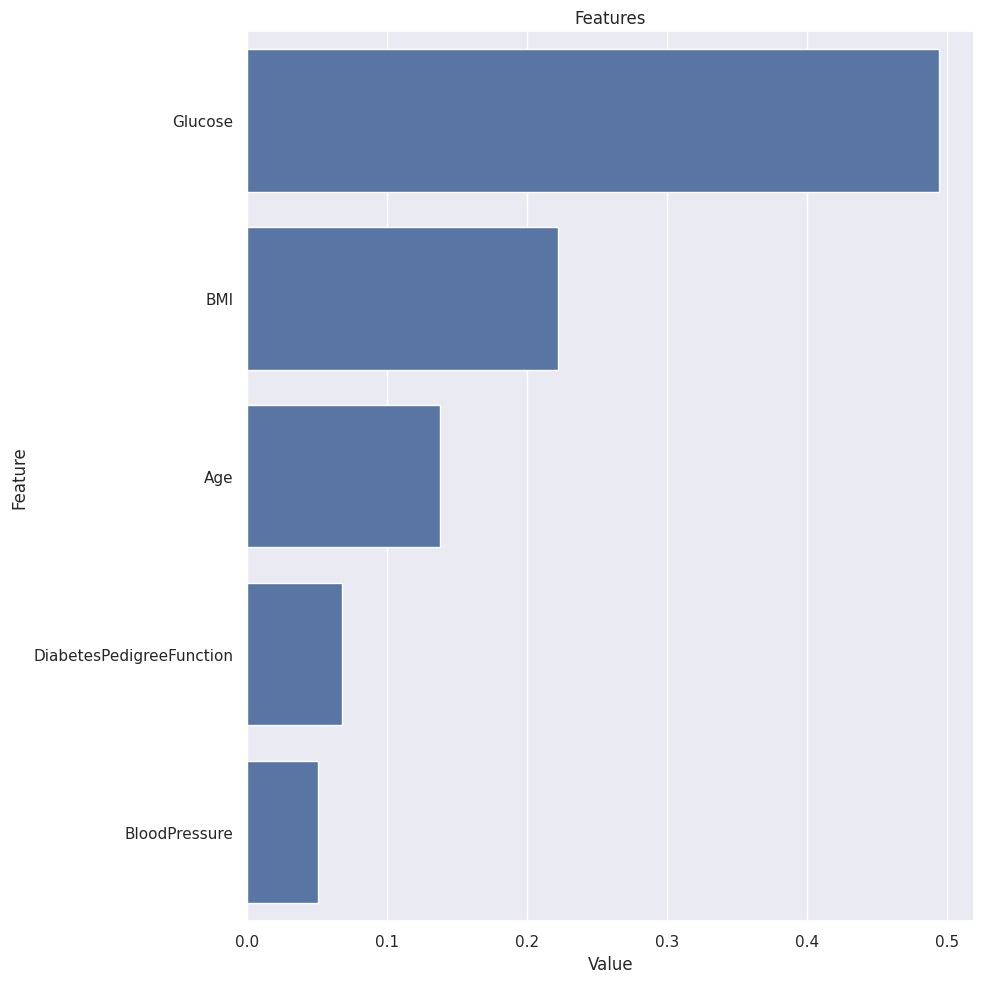

In [130]:
cart_final.feature_importances_

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(cart_final, X, num=5)  # If we want to bring the first 5 variables instead of all variables, we can say num = 5.

In the chart above, when we list our variables according to feature importance, we see the first 5 variables. The top 3 variables are Glucose, BMI and Age.

# Feature Engineering

If we add new features, will our model success in Logistic Regression, KNN and CART models increase? We will look at this:

This time we will proceed functionally to avoid repeating the same operations:

In [131]:
# Defining categorical and numerical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [132]:
# We may need to encode the new variables we add.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [133]:
# The function we wrote for data preprocessing and future engineering operations
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]  #We convert all variable names to uppercase so that they are in the same format.

    #new variables
    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)  # Parsing of variable types

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

df = pd.read_csv("/content/diabetes.csv")


X, y = diabetes_data_prep(df)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
0,6,148,72,35,0,33.600,0.627,50,1,prediabetes,middleage,obese,normal
1,1,85,66,29,0,26.600,0.351,31,0,normal,young,overweight,normal
2,8,183,64,0,0,23.300,0.672,32,1,prediabetes,young,healty,normal
3,1,89,66,23,94,28.100,0.167,21,0,normal,young,overweight,normal
4,0,137,40,35,168,43.100,2.288,33,1,normal,young,obese,normal


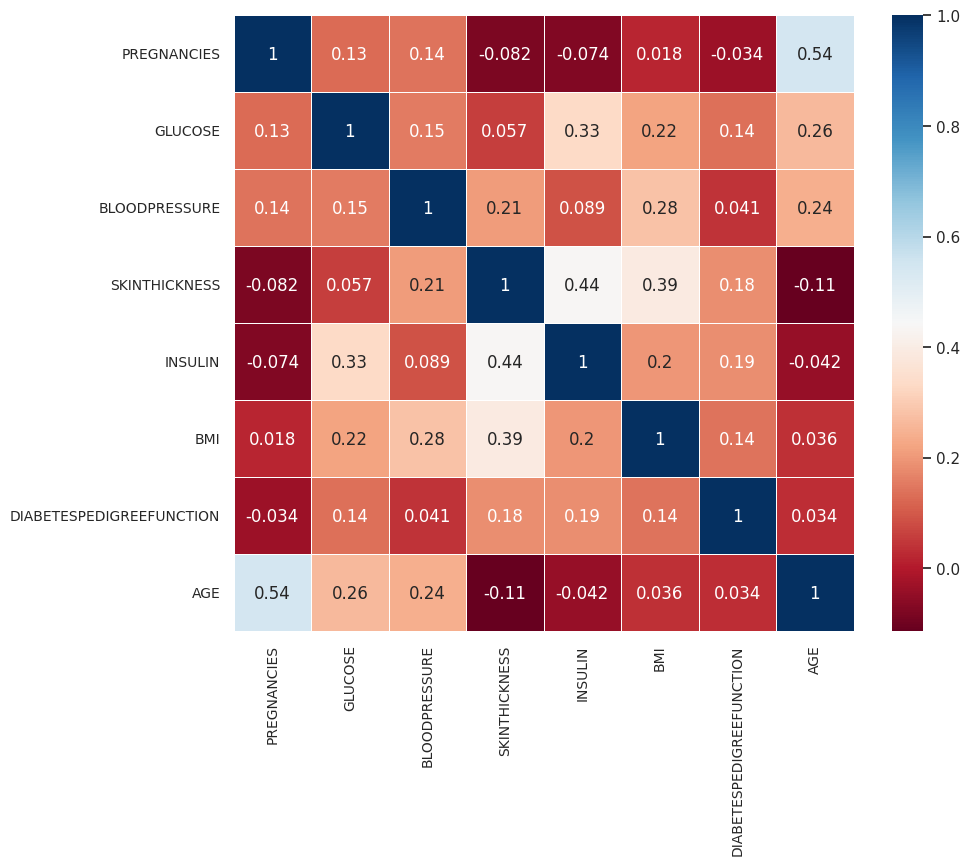

In [134]:
# Parsing of variable types
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# Correlation of numerical variables with each other
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
correlation_matrix(df, num_cols)


The graph above contains a heat map where we can see the correlation of variables with each other. There are no highly correlated variables except age and number of pregnancies (0.54).

# 3. Base Models

In [135]:
def base_models(X, y, scoring="accuracy"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("CART", DecisionTreeClassifier())
                  ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7591 (LR) 
accuracy: 0.75 (KNN) 
accuracy: 0.6927 (CART) 


In [136]:
# Before adding new features, after cross validation, before hyperparameter optimization:
# Accuracy:  0.77 (LR)
# Accuracy:  0.73 (KNN)
# Accuracy:  0.70 (CART)

# After adding new features, after cross validation, before hyperparameter optimization:
# Accuracy:  0.7591 (LR)
# Accuracy:  0.75 (KNN)
# Accuracy:  0.6927  (CART)

# 4. Automated Hyperparameter Optimization

In [137]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
              ]

In [138]:
def hyperparameter_optimization(X, y, cv=3, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.75
accuracy (After): 0.7747
KNN best params: {'n_neighbors': 16}

########## CART ##########
accuracy (Before): 0.6823
accuracy (After): 0.7422
CART best params: {'max_depth': 6, 'min_samples_split': 25}



In [139]:
# Before adding new features, after cross validation, before hyperparameter optimization:
# Accuracy:  0.77 (LR)*
# Accuracy:  0.73 (KNN)
# Accuracy:  0.70 (CART)

# Before adding new features, after cross validation, after hyperparameter optimization: Result: Effective
# Accuracy:  0.77 (LR)*
# Accuracy:  0.76 (KNN)
# Accuracy:  0.75 (CART)

# After adding new features, after cross validation, before hyperparameter optimization:
# Accuracy:  0.7591 (LR)**
# Accuracy:  0.75 (KNN)
# Accuracy:  0.68  (CART)

# After adding new features, after cross validation, after hyperparameter optimization:
# Accuracy:  0.7591 (LR)**
# Accuracy:  0.7747 (KNN)
# Accuracy:  0.74 (CART)

# **Not: LR'de hiperparametre optimizasyonu olmadığı için LR'nin hiperparametre optimizasyonunudan sonraki değerlerinde değişiklik olmadı.

# Results:
  
  *We added new variables, but it did not have much effect. One can be more creative with new variables. By doing a little more literature research, variables that may be effective can be found.

*The hyperparameter optimizations we made for KNN and CART were effective.

*The best model according to Accuracy value: The Logistic Regression Model before adding new variables and the KNN Model after adding variables appear to be the best models.

*Result: Hyperparameter optimization was effective in all cases, but the addition of new features did not have a huge impact: (very little increase in KNN, decrease in LR and CART)